In [1]:
pip install -U "jax[cuda12]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.3
    Uninstalling jax-cuda12-pjrt-0.5.3:
      Successfully uninstalled jax-cuda12-pjrt-0.5.3
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.5.3
    Uninstalling jax-cud

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import cupy as cp

import matplotlib.pyplot as plt

import time

In [9]:
def gelu_cp(x):
    return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / cp.pi) * (x + 0.044715 * x**3)))

def lnorm_cp(x, eps=1e-5):
    mean = cp.mean(x, axis=0, keepdims=True)
    var = cp.var(x, axis=0, keepdims=True)
    return (x - mean) / cp.sqrt(var + eps)

def softmax_cp(x, axis=-1):

    x_max = cp.max(x, axis=axis, keepdims=True)
    e_x = cp.exp(x - x_max)
    return e_x / cp.sum(e_x, axis=axis, keepdims=True)

def matmul_cp(a, b):
    a_i32 = a.astype(cp.int32)
    b_i32 = b.astype(cp.int32)
    result = a_i32 @ b_i32
    return cp.clip(result, -128, 127).astype(cp.int8)

def attention_per_head_cp(K, Q, V, l, ddh, b, h):
    lb = l * b
    E2 = cp.zeros((K.shape[0], lb), dtype=cp.int32)

    K_i32 = K.astype(cp.int32)
    Q_i32 = Q.astype(cp.int32)
    V_i32 = V.astype(cp.int32)

    for j in range(b):
        for i in range(h):
            indJ = j * l
            indI2 = i * ddh
            K_slice = K_i32[indI2:indI2+ddh, indJ:indJ+l]
            Q_slice = Q_i32[indI2:indI2+ddh, indJ:indJ+l]
            E1 = K_slice.T @ Q_slice
            V_slice = V_i32[indI2:indI2+ddh, indJ:indJ+l]

            scores = K_slice.T @ Q_slice / cp.sqrt(ddh)
            E1 = softmax_cp(scores, axis=0)
            result = V_slice @ E1

            E2[indI2:indI2+ddh, indJ:indJ+l] = cp.clip(result, -128, 127).astype(cp.int8)
    return E2

def mha_output_cp(WO, E2, EI):
    WO_i32 = WO.astype(cp.int32)
    E2_i32 = E2.astype(cp.int32)
    EI_i32 = EI.astype(cp.int32)
    result = EI_i32 + WO_i32 @ E2_i32
    return cp.clip(result, -128, 127).astype(cp.int8)

def ffn_forward_cp(W1, W2, AO):
    W1_i32 = W1.astype(cp.int32)
    W2_i32 = W2.astype(cp.int32)
    AO_i32 = AO.astype(cp.int32)
    result = AO_i32 + W2_i32 @ (W1_i32 @ AO_i32)
    return cp.clip(result, -128, 127).astype(cp.int8)

In [4]:

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)




def softmax_jax(x, axis=-1):
    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)


def matmul_jax(a, b):
    a_i32= a.astype(jnp.int32)
    b_i32= b.astype(jnp.int32)
    c = a_i32 @ b_i32
    return jnp.clip(c, -128, 127).astype(jnp.int8)


def attention_per_head_jax(K, Q, V, l_total, ddh, b, h):
    K= K.astype(jnp.int32)
    Q= Q.astype(jnp.int32)
    V= V.astype(jnp.int32)
    lb = l_total * b
    d = K.shape[0]
    E2_init = jnp.zeros((d, lb), dtype=jnp.int32)


    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j * l_total
        indI2 = i * ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)

        scores = K_slice.T @ Q_slice / jnp.sqrt(ddh)
        E1 = softmax_jax(scores, axis=0)

        result = V_slice @ E1
        result_int8 = jnp.clip(result, -128, 127).astype(jnp.int8)
        E2 = lax.dynamic_update_slice(E2, result_int8, (indI2, indJ))
        return E2, None
    E2_init = jnp.zeros((d, lb), dtype=jnp.int8)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)
    return E2


def mha_output_jax(WO, E2, EI):
    E2 = E2.astype(jnp.int32)
    EI = EI.astype(jnp.int32)
    WO = WO.astype(jnp.int32)
    AO = WO @ E2 + EI
    AO = lnorm_jax(AO)
    return jnp.clip(AO, -128, 127).astype(jnp.int8)


def ffn_forward_jax(W1, W2, AO):
    AO = AO.astype(jnp.int32)
    W1 = W1.astype(jnp.int32)
    W2 = W2.astype(jnp.int32)
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3
    EO = lnorm_jax(EOb + AO)
    return jnp.clip(EO, -128, 127).astype(jnp.int8)


b = 24
l = 128
d = 1024
h = 16


f = 4 * d
ddh = d // h
lb = b * l



In [5]:

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)



EI_jax = jax.random.randint(keys[0], (d, lb), minval=-128, maxval=128, dtype=jnp.int8)
WQ = jax.random.randint(keys[1], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WK = jax.random.randint(keys[2], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WV = jax.random.randint(keys[3], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WO = jax.random.randint(keys[4], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
W1 = jax.random.randint(keys[5], (f, d), minval=-128, maxval=128, dtype=jnp.int8)
W2 = jax.random.randint(keys[6], (d, f), minval=-128, maxval=128, dtype=jnp.int8)



In [6]:
EI_cp = cp.zeros( (d, lb),  dtype=cp.float32)
WQ_cp = cp.zeros( (d, d), dtype=cp.float32)
WK_cp = cp.zeros( (d, d),  dtype=cp.float32)
WV_cp = cp.zeros((d, d),  dtype=cp.float32)
WO_cp = cp.zeros( (d, d),  dtype=cp.float32)
W1_cp = cp.zeros( (f, d),  dtype=cp.float32)
W2_cp = cp.zeros((d, f),dtype=cp.float32)

In [7]:
jax.config.update('jax_default_matmul_precision', 'highest')

In [10]:
# CuPy



results={}
results["CuPy"] = {}
Qc = matmul_cp(WQ_cp, EI_cp)
cp.cuda.Stream.null.synchronize()


start = time.time()
Qc = matmul_cp(WQ_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_Q"] = end - start

start = time.time()
Kc = matmul_cp(WK_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_cp(WV_cp, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["matmul_V"] = end - start

start = time.time()
E2n = attention_per_head_cp(Kc, Qc, Vc, l, ddh, b, h)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["attention"] = end - start

start = time.time()
AOc = mha_output_cp(WO_cp, E2n, EI_cp)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["mha_output"] = end - start

start = time.time()
EOc = ffn_forward_cp(W1_cp, W2_cp, AOc)
cp.cuda.Stream.null.synchronize()
end = time.time()
results["CuPy"]["ffn"] = end - start

results["CuPy"]["total"] = sum(results["CuPy"].values())

In [11]:

# JAX without JIT
results["JAX"] = {}

Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_jax(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())

print(results["JAX"])


{'matmul_Q': 0.04548239707946777, 'matmul_K': 0.044181108474731445, 'matmul_V': 0.047586917877197266, 'attention': 0.8939886093139648, 'mha_output': 1.2086093425750732, 'ffn': 1.3964662551879883, 'total': 3.636314630508423}


In [12]:
results["JIT-COMP"] = {}

# JIT

matmul_jit= jax.jit(matmul_jax)
attention_per_head_jit = jax.jit(attention_per_head_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)



start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start


start_attention=  time.time()
E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())



In [13]:
# JAX with JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start

start_attention=  time.time()
E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

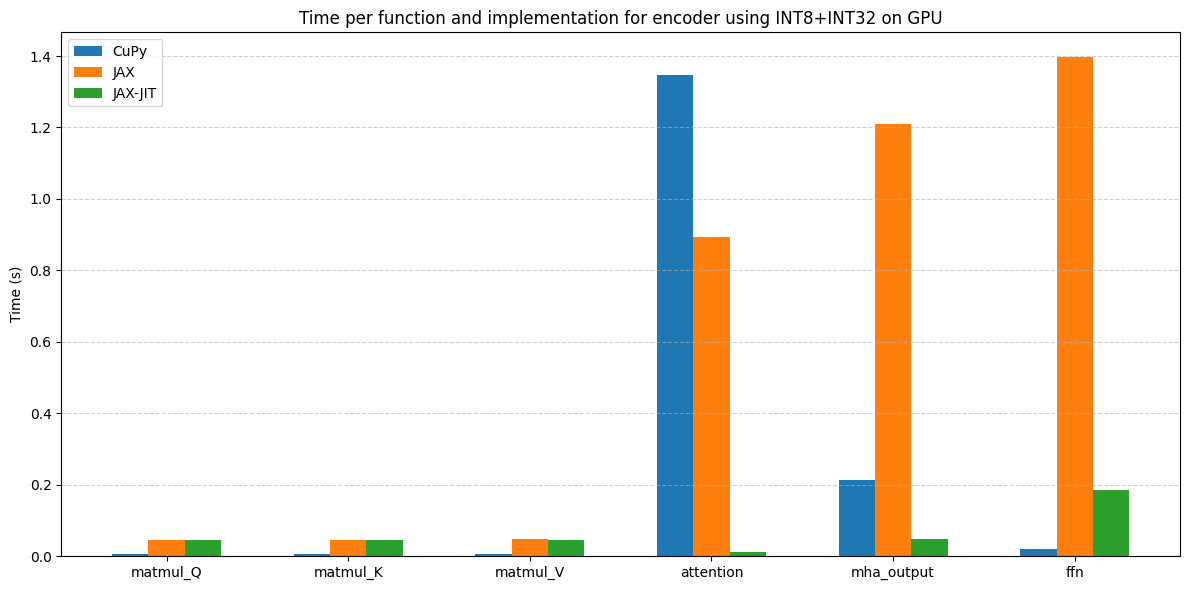

In [14]:



labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20
fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - 1*width, [results["CuPy"][l] for l in labels], width, label='CuPy')
ax.bar(x + 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function and implementation for encoder using INT8+INT32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()



plt.show()

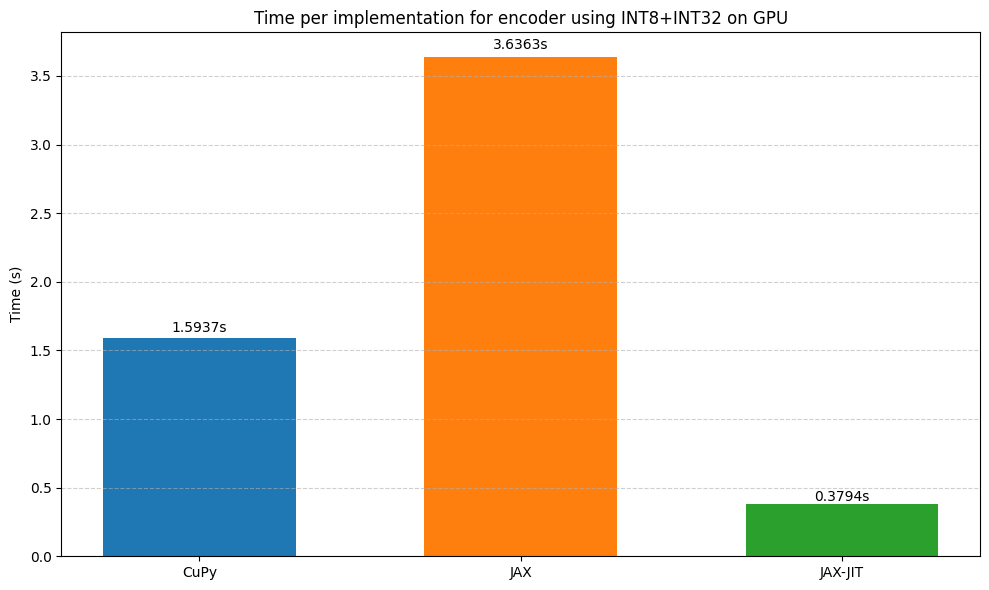

In [15]:

labels = ["CuPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Time per implementation for encoder using INT8+INT32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()



plt.show()

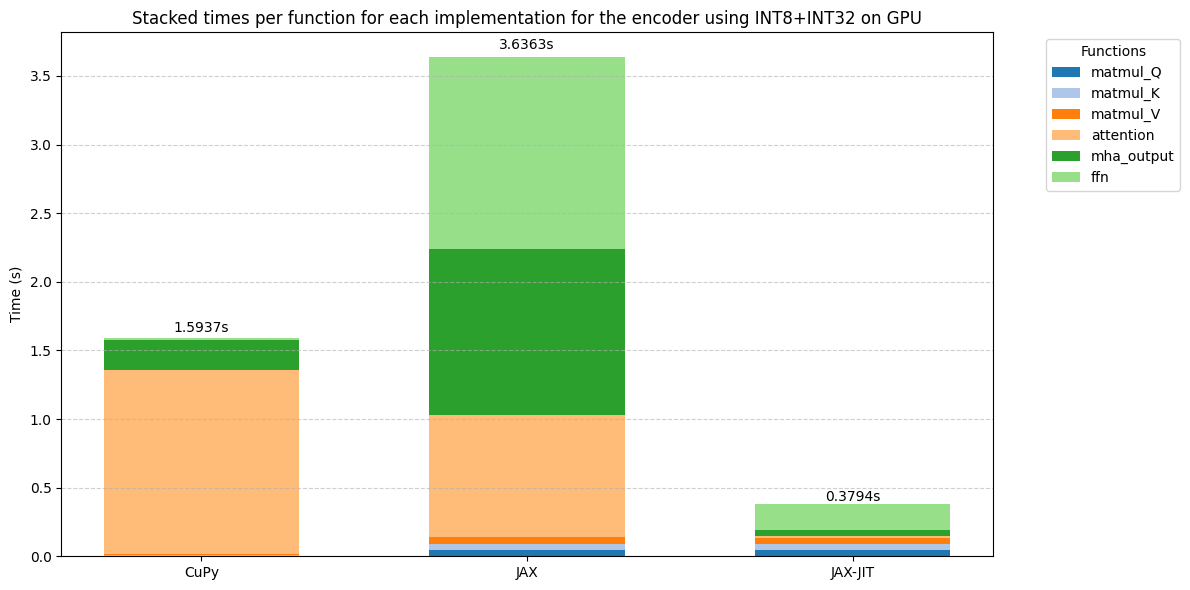

In [16]:

implementations = ["CuPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(implementations))

for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the encoder using INT8+INT32 on GPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)

ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [17]:
import pandas as pd

df = pd.DataFrame(results).T
cols_orden = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn", "total"]
df = df[cols_orden]


display(df.style.format("{:.4f}"))







,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
CuPy,0.0050,0.0050,0.0050,1.3459,0.2138,0.0192,1.5937
JAX,0.0455,0.0442,0.0476,0.8940,1.2086,1.3965,3.6363
JIT-COMP,0.1674,0.0442,0.0442,0.2982,0.3192,0.8380,1.7113
JAX-JIT,0.0460,0.0457,0.0450,0.0112,0.0466,0.1849,0.3794
